# Testing out Turing.jl and LV demo
Following [demo code](https://turing.ml/dev/tutorials/10-bayesian-differential-equations/) examples.

In [1]:
using Turing
using DifferentialEquations

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Set a seed for reproducibility.
using Random
Random.seed!(14);

## LV demo

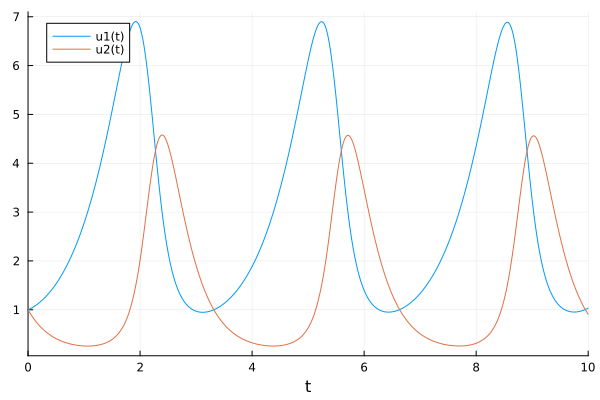

In [2]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [1.0, 1.0]
p = [1.5, 1.0, 3.0, 1.0]
tspan = (0.0, 10.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p)

# Plot simulation.
plot(solve(prob, Tsit5()))

## Making syntehtic observations

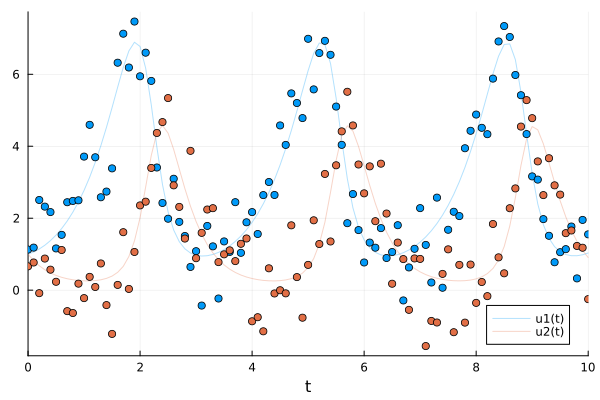

In [3]:
sol = solve(prob, Tsit5(); saveat=0.1)
odedata = Array(sol) + 0.8 * randn(size(Array(sol)))

# Plot simulation and noisy observations.
plot(sol; alpha=0.3)
scatter!(sol.t, odedata'; color=[1 2], label="")

## Fitting a model

In [4]:
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
    β ~ truncated(Normal(1.2, 0.5); lower=0, upper=2)
    γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)
    δ ~ truncated(Normal(1.0, 0.5); lower=0, upper=2)

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

model = fitlv(odedata, prob)

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(0.65), MCMCSerial(), 1000, 5; progress=false)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /disk/scratch/s2125151/opt/julia_depot/packages/AdvancedHMC/eLdgX/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /disk/scratch/s2125151/opt/julia_depot/packages/AdvancedHMC/eLdgX/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /disk/scratch/s2125151/opt/julia_depot/packages/AdvancedHMC/eLdgX/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /disk/scratch/s2125151/opt/julia_depot/packages/AdvancedHMC/eLdgX/src/hamiltonian.j

Chains MCMC chain (1000×17×5 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 5
Samples per chain = 1000
Wall duration     = 93.54 seconds
Compute duration  = 91.2 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

           σ    1.2800    0.6199     0.0088    0.0727   10.1413    9.2957      ⋯
           α    1.3594    0.1555     0.0022    0.0158   13.9814    1.9402      ⋯
           β    0.9383    0.1083     0.0015    0.0089   21.2449    1.3996      ⋯
           γ    2.3415    0.9764     0.0138    0.1143   10.2540    6.7838      ⋯
           δ    0.8621    0.2377     0.0034    0.0270   11.0

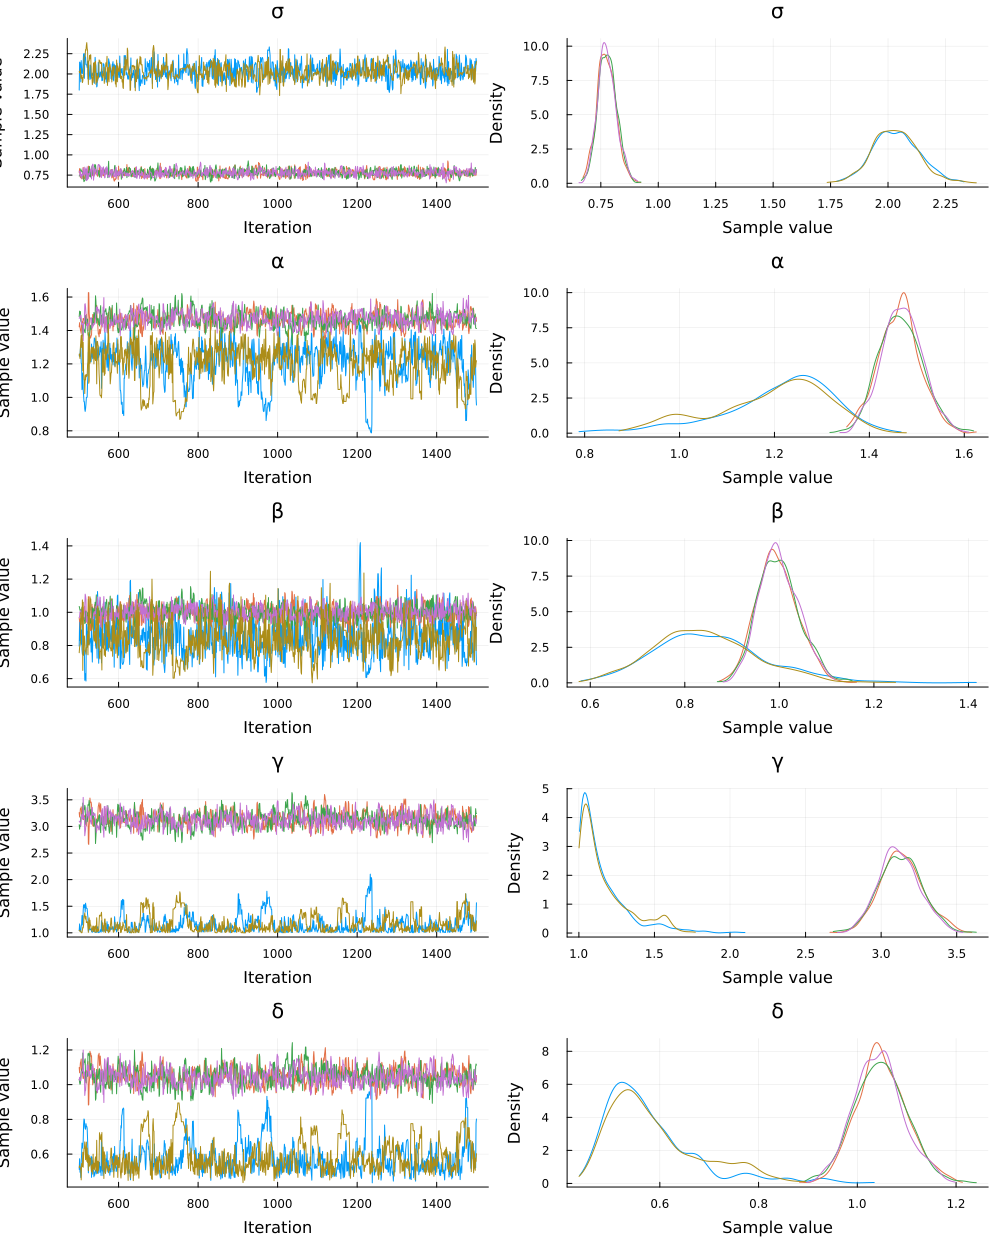

In [5]:
plot(chain)